<a href="https://colab.research.google.com/github/Jakondo/Python-for-DL-and-CV/blob/master/Ch10_Transfer_Learning_PyTorch_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chapter 10: Transfer Learning - PyTorch

---



In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models

In [0]:
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

In [20]:
!git clone https://github.com/jaddoescad/ants_and_bees.git

fatal: destination path 'ants_and_bees' already exists and is not an empty directory.


In [0]:
transform_train = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))
                                      ])

transform = transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])

training_dataset = datasets.ImageFolder('ants_and_bees/train', transform=transform_train)
validation_dataset = datasets.ImageFolder('ants_and_bees/val', transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=20, shuffle=False)

In [22]:
print(len(training_dataset))
print(len(validation_dataset))

244
153


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [0]:
classes = ('ant', 'bee')

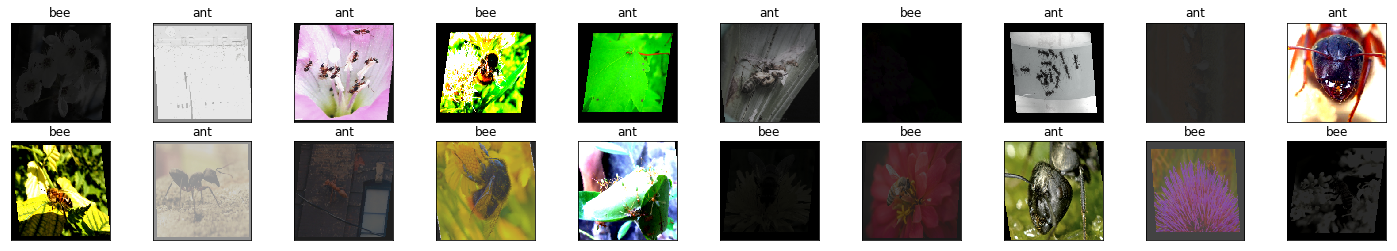

In [44]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [45]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:19<00:00, 28191762.10it/s]


In [0]:
#Заморозка параметров предобученной модели
for param in model.parameters():
  param.requires_grad = False

In [47]:
#Создание нового слоя нейронной сети с 2-мя выходами
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [49]:
epochs = 10
loss_hist = []
correct_hist = []
val_loss_hist = []
val_cor_hist = []

for e in range(epochs):
  run_loss = 0.0
  run_correct = 0.0
  val_run_loss = 0.0
  val_run_cor = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)    
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    run_correct += torch.sum(preds == labels.data)    
    run_loss += loss.item()
    
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)    
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_run_cor += torch.sum(val_preds == val_labels.data)    
        val_run_loss += val_loss.item()
      
    epoch_loss = run_loss/len(training_loader.dataset)
    epoch_acc = run_correct.float()/len(training_loader.dataset)
    loss_hist.append(epoch_loss)
    correct_hist.append(epoch_acc)
    
    val_epoch_loss = val_run_loss/len(validation_loader.dataset)
    val_epoch_acc = val_run_cor.float()/len(validation_loader.dataset)
    val_loss_hist.append(val_epoch_loss)
    val_cor_hist.append(val_epoch_acc)
    
    print('epoch: ', (e+1))    
    print('training loss: {:.4f}, accuracy {:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, accuracy {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

epoch:  1
training loss: 0.0379, accuracy 0.5164
validation loss: 0.0342, accuracy 0.5752
epoch:  2
training loss: 0.0346, accuracy 0.5984
validation loss: 0.0287, accuracy 0.7516
epoch:  3
training loss: 0.0317, accuracy 0.7377
validation loss: 0.0240, accuracy 0.8170
epoch:  4
training loss: 0.0299, accuracy 0.7254
validation loss: 0.0213, accuracy 0.8431
epoch:  5
training loss: 0.0264, accuracy 0.7787
validation loss: 0.0204, accuracy 0.8693
epoch:  6
training loss: 0.0250, accuracy 0.7828
validation loss: 0.0179, accuracy 0.8693
epoch:  7
training loss: 0.0227, accuracy 0.7910
validation loss: 0.0164, accuracy 0.8824
epoch:  8
training loss: 0.0233, accuracy 0.8443
validation loss: 0.0150, accuracy 0.8954
epoch:  9
training loss: 0.0240, accuracy 0.7705
validation loss: 0.0149, accuracy 0.9085
epoch:  10
training loss: 0.0198, accuracy 0.8279
validation loss: 0.0142, accuracy 0.9150


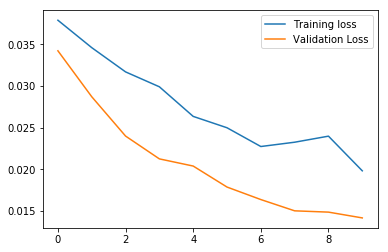

In [50]:
plt.plot(loss_hist, label='Training loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.legend();

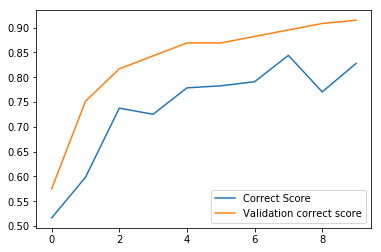

In [51]:
plt.plot(correct_hist, label='Correct Score')
plt.plot(val_cor_hist, label='Validation correct score')
plt.legend();

#Test

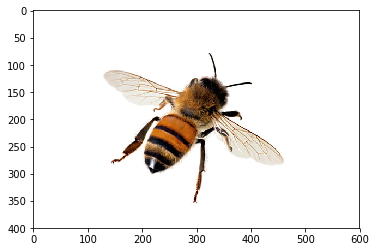

In [52]:
import requests
import PIL.ImageOps
from PIL import Image
url = 'https://www.ahs.com/static-srvm/trmx/blog-images/How-To-Tell-If-Youre-Allergic-To-A-Bee-Sting-Main.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img);

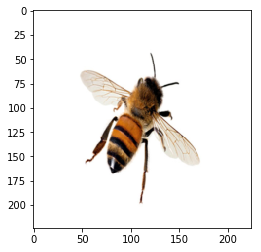

In [53]:
img = transform(img)
plt.imshow(im_convert(img));

In [54]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

bee


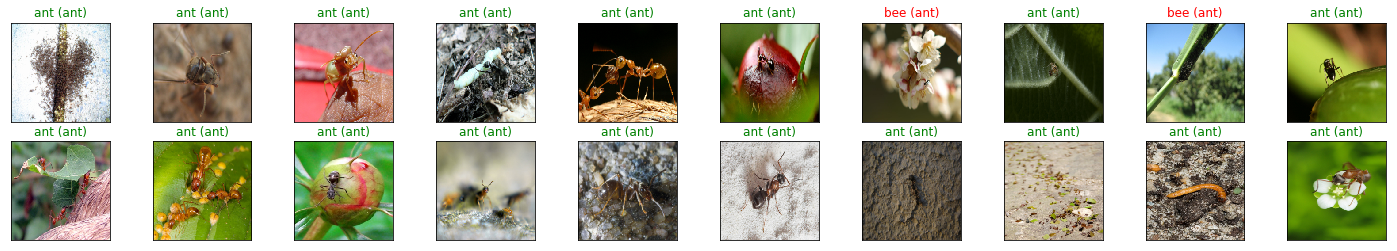

In [55]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)

output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))
  